In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
chk = pd.read_csv('./dataset.csv')
mols = pd.read_csv('../genetic_algorithm/test.csv')

In [3]:
chk.columns = ['name', 'score']
chk.head()

,name,score
0,0_6_4361,-10.033333
1,4_2_6567,-12.700000
2,1_4_350,-12.500000
3,0_6_571,-9.666667
4,2_2_62,-12.433333


In [4]:
chk.shape

(76984, 2)

In [5]:
mols.head()

,name,smiles
0,0_0_0,O=C(CCCC[C@@H]1CCSS1)NCCCCCCNC(=O)c1ccc(-c2c3n...
1,0_0_1,O=C(NCCCCCCNC(=O)c1ccc(-c2c3nc(c(-c4c(F)c(F)c(...
2,0_0_2,Nc1c(CC(=O)NCCCCCCNC(=O)c2ccc(-c3c4nc(c(-c5c(F...
3,0_0_3,CC(C)(C)c1cc2c(cc1Cl)C=C(C(=O)NCCCCCCNC(=O)c1c...
4,0_0_4,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)NCCCCCCNC(=O)c1cc...


In [6]:
merged = pd.merge(chk, mols, on='name', how='left')

In [7]:
merged.head()

,name,score,smiles
0,0_6_4361,-10.033333,O=C(OCCOCCOCCOCCOC(=O)c1ccc(S(=O)(=O)Nc2ccccc2...
1,4_2_6567,-12.700000,Cc1ccccc1N(CCC(=O)NCCCNC(=O)c1ccc(-c2c3nc(c(-c...
2,1_4_350,-12.500000,CS(=O)(=O)c1ccc(-c2cc(Cl)cc3c2OC(C(F)(F)F)C(C(...
3,0_6_571,-9.666667,COc1ccccc1[C@@H]1CN(Cc2cc(C(C)=O)cn2C)C[C@H]1C...
4,2_2_62,-12.433333,CCCc1cc(S(F)(F)(F)(F)F)cc2c1OC(C(F)(F)F)C(C(=O...


In [8]:
merged.shape

(77491, 3)

In [9]:
merged.drop_duplicates(inplace=True)

In [10]:
merged.head()

,name,score,smiles
0,0_6_4361,-10.033333,O=C(OCCOCCOCCOCCOC(=O)c1ccc(S(=O)(=O)Nc2ccccc2...
1,4_2_6567,-12.700000,Cc1ccccc1N(CCC(=O)NCCCNC(=O)c1ccc(-c2c3nc(c(-c...
2,1_4_350,-12.500000,CS(=O)(=O)c1ccc(-c2cc(Cl)cc3c2OC(C(F)(F)F)C(C(...
3,0_6_571,-9.666667,COc1ccccc1[C@@H]1CN(Cc2cc(C(C)=O)cn2C)C[C@H]1C...
4,2_2_62,-12.433333,CCCc1cc(S(F)(F)(F)(F)F)cc2c1OC(C(F)(F)F)C(C(=O...


In [11]:
def could_be_mol(smiles):
    try:
        Chem.MolFromSmiles(smiles)
        return True
    except:
        return False

In [12]:
if os.path.exists('./ready_dataset.csv'):
    merged = pd.read_csv('./ready_dataset.csv')
else:
    merged['could_be_mol'] = merged['smiles'].apply(could_be_mol)
    print(merged['could_be_mol'].value_counts())
    merged = merged[merged['could_be_mol']]
    merged.to_csv('./ready_dataset.csv', index=False)

In [13]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [14]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [15]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [16]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [17]:
import time
CALLS = []
target = merged.score.values
def get_score(id):
    global CALLS
    CALLS.append(id)
    return target[id]

In [18]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
class ChemicalSpace:
    def __init__(self, file):
        if file.split('.')[-1] == 'csv':
            compounds = pd.read_csv(file, delimiter = ",", nrows=30000)
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        self.compounds['mol'] = self.compounds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
        self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        self.mol2vec = [DfVec(x) for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')]
        self.mol2vec = np.array([x.vec for x in self.mol2vec])
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
        self.iter_neighbors = []
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def reset_neighbors(self):
        self.iter_neighbors = []
    def add_step_neighbors(self, neighbors):
        self.iter_neighbors.append(neighbors)
    def f(self, X):
        if not isinstance(X, torch.Tensor):
            warnings.warn("X is not a torch tensor. Converting to torch tensor...")
            X = torch.tensor(X, dtype=torch.float, requires_grad=True)
        X_numpy = X.detach().numpy()
        # get neighbors
        neighbors = self.get_neighbors(X_numpy)[0]
        # add neighbors to list of neighbors
        self.add_step_neighbors(neighbors)
        # get scores of neighbors
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float64, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)
        # f(x) = distance weighted average of neighbors
        # distance weighted average = sum of scores * (1 / distance)
        distance_sum = torch.sum(1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)), dtype=torch.float64)
        scores = torch.sum(scores * (1 / torch.sqrt(torch.sum((coords - X)**2, axis=1))), dtype=torch.float64) / distance_sum
        return torch.mean(scores)

In [19]:
smi = 'ready_dataset.csv'

In [20]:
merged.head()

,Unnamed: 0,name,score,smiles,could_be_mol
0,0,0_6_4361,-10.033333,O=C(OCCOCCOCCOCCOC(=O)c1ccc(S(=O)(=O)Nc2ccccc2...,True
1,1,4_2_6567,-12.700000,Cc1ccccc1N(CCC(=O)NCCCNC(=O)c1ccc(-c2c3nc(c(-c...,True
2,2,1_4_350,-12.500000,CS(=O)(=O)c1ccc(-c2cc(Cl)cc3c2OC(C(F)(F)F)C(C(...,True
3,3,0_6_571,-9.666667,COc1ccccc1[C@@H]1CN(Cc2cc(C(C)=O)cn2C)C[C@H]1C...,True
4,4,2_2_62,-12.433333,CCCc1cc(S(F)(F)(F)(F)F)cc2c1OC(C(F)(F)F)C(C(=O...,True


In [21]:
space = ChemicalSpace(smi)

In [22]:
space.mol2vec[0]

array([ 14.376137  , -14.874268  , -19.06081   ,  23.927845  ,
        -7.5689087 ,  -0.9825865 , -43.04241   ,  -1.5466009 ,
        36.4954    ,  15.759689  ,  -5.480368  ,   0.89188856,
       -40.712368  ,   4.8019485 , -21.490368  , -12.90775   ,
        10.083531  , -26.754519  , -11.808341  ,  21.956903  ,
        14.904582  ,  14.615276  ,  61.246468  ,  38.03927   ,
       -41.30833   ,   6.4789996 ,  -9.706294  , -35.62874   ,
        -6.51486   ,   4.6214385 ,  44.07613   , -32.68723   ,
       -18.614876  , -21.473007  ,  21.455706  ,   5.4099    ,
        12.538794  ,  -8.391206  ,  39.588703  ,   0.4516902 ,
       -11.140402  ,  -8.053558  ,  -5.652243  ,   1.7437444 ,
       -48.810173  ,  20.083408  ,  -0.9340114 ,  39.996185  ,
       -24.84937   ,  23.399084  ,  18.37509   , -25.399073  ,
       -14.554012  , -31.505663  , -29.245201  , -17.327383  ,
       -10.826802  ,   5.961473  ,  14.558371  ,  18.469063  ,
        -6.022935  , -33.007328  ,  -4.7353306 ,   8.75

In [24]:
space.init_knn(n_neighbors=10)

In [25]:
space.get_neighbors(space.mol2vec[7])

array([[    7, 17470,  6501, 20274,  2738,  3009, 15114,  1503, 14699,
        25665]])

In [26]:
space.get_neighbors(space.mol2vec[844])

array([[  844, 20928, 24058, 20818, 14578, 19592, 18333,  5612,  5420,
        17953]])

In [27]:
space.set_objective(get_score)

In [28]:
space.get_objective(84)

-10.633333333333333

In [29]:
%%time
space.get_objective(8)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 17.6 µs


-11.133333333333333

In [30]:
%%time
space.get_objective(8)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs


-11.133333333333333

In [31]:
debug_vector = torch.rand(300, requires_grad=True)

In [33]:
space.f(debug_vector)

tensor(-9.4160, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [34]:
from utils import *
global_seed(654)

Global seed set to 654


In [35]:
def create_distribs(mol2vec):
    means = np.ones(mol2vec.shape[1])
    stds = np.ones(mol2vec.shape[1])
    for i in range(mol2vec.shape[1]):
        means[i] = np.mean(mol2vec[:, i])
        stds[i] = np.std(mol2vec[:, i])
    return means, stds

In [36]:
means, stds = create_distribs(space.mol2vec)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of features in latent space')

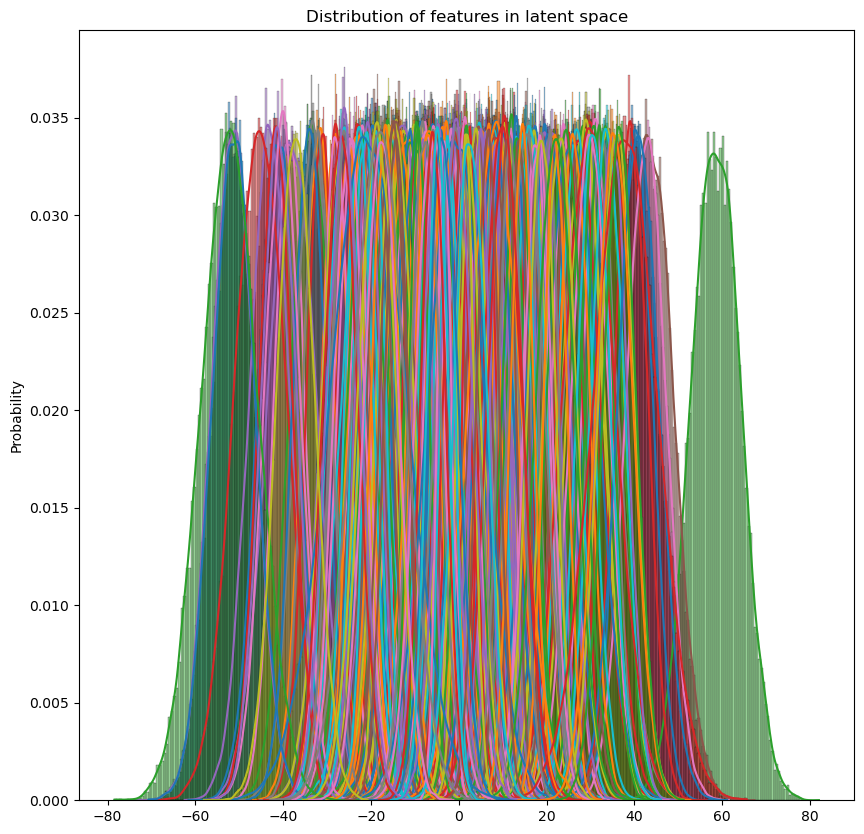

In [37]:
import seaborn as sns
# plot all means as distribution
numeric_dists = [np.random.normal(means[i], stds[i], 30000) for i in range(len(means))]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in tqdm(range(len(numeric_dists))):    
    sns.histplot(numeric_dists[i], ax=ax, label=f'feature {i}', kde=True, stat='probability')
ax.set_title('Distribution of features in latent space')

In [38]:
def sample_from_distribs(means, stds):
    return np.random.normal(means, stds)

In [39]:
# optimize f(x)
X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)

In [40]:
from torch.optim import Adam
optimizer = Adam([X], lr=10)

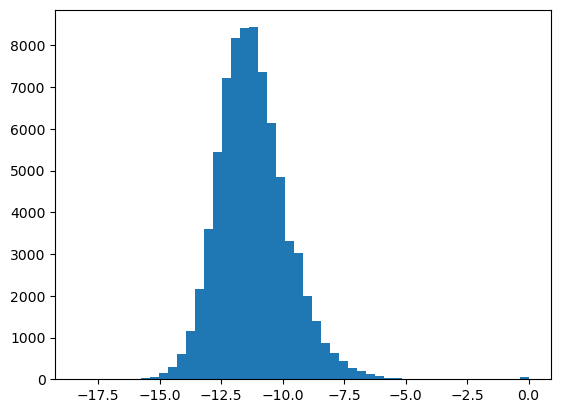

In [41]:
_ = plt.hist(target, bins=50)

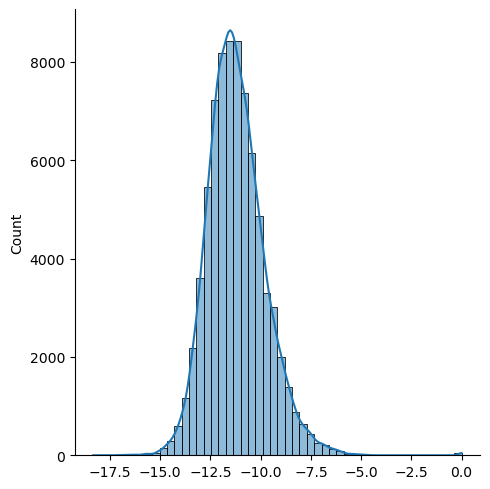

In [42]:
import seaborn as sns
_=sns.displot(target, bins=50, kde=True)

In [41]:
CALLS = []
best = 0
for i in range(10000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    if loss.item() < best:
        best = loss.item()
    if i % 500 == 0:
        print(f'Iteration: {i}', f'Loss: {loss.item()}')

Iteration: 0 Loss: -11.80746560643202
Iteration: 500 Loss: -14.620914011898336
Iteration: 1000 Loss: -14.573614513499571
Iteration: 1500 Loss: -14.362666206930909
Iteration: 2000 Loss: -13.221411481917094
Iteration: 2500 Loss: -13.510357321874345
Iteration: 3000 Loss: -13.797588994589788
Iteration: 3500 Loss: -14.086908858317017
Iteration: 4000 Loss: -14.350508377789422
Iteration: 4500 Loss: -13.586799588268212
Iteration: 5000 Loss: -13.64684582281664
Iteration: 5500 Loss: -13.647127491343682
Iteration: 6000 Loss: -13.340073234216197
Iteration: 6500 Loss: -13.273788244351303
Iteration: 7000 Loss: -13.710210622881416
Iteration: 7500 Loss: -12.616643506742827
Iteration: 8000 Loss: -12.686700902271438
Iteration: 8500 Loss: -12.690068797545035
Iteration: 9000 Loss: -13.273377832824432
Iteration: 9500 Loss: -13.340145034514478


In [42]:
from scipy.stats import percentileofscore
# flatten list of lists
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')

Visited 502 unique compounds
Best score: -15.015112099947036
Percentile: 0.16178696310213453


In [88]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [44]:
for lr in lrs:
    space.reset_neighbors()
    print(f'Learning rate: {lr}')
    global_seed(676550)
    X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in tqdm(range(5000)):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            lrs_timeline[lr].append(loss.item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(unique_comps(space.iter_neighbors))

Learning rate: 0.0001
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 23 points
Learning rate: 0.001
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 21 points
Learning rate: 0.01
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 4 points
Learning rate: 0.1
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 0 points
Learning rate: 1
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 29 points
Learning rate: 10
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 208 points
Learning rate: 100
Global seed set to 676550


  0%|          | 0/5000 [00:00<?, ?it/s]

Visited 52 points


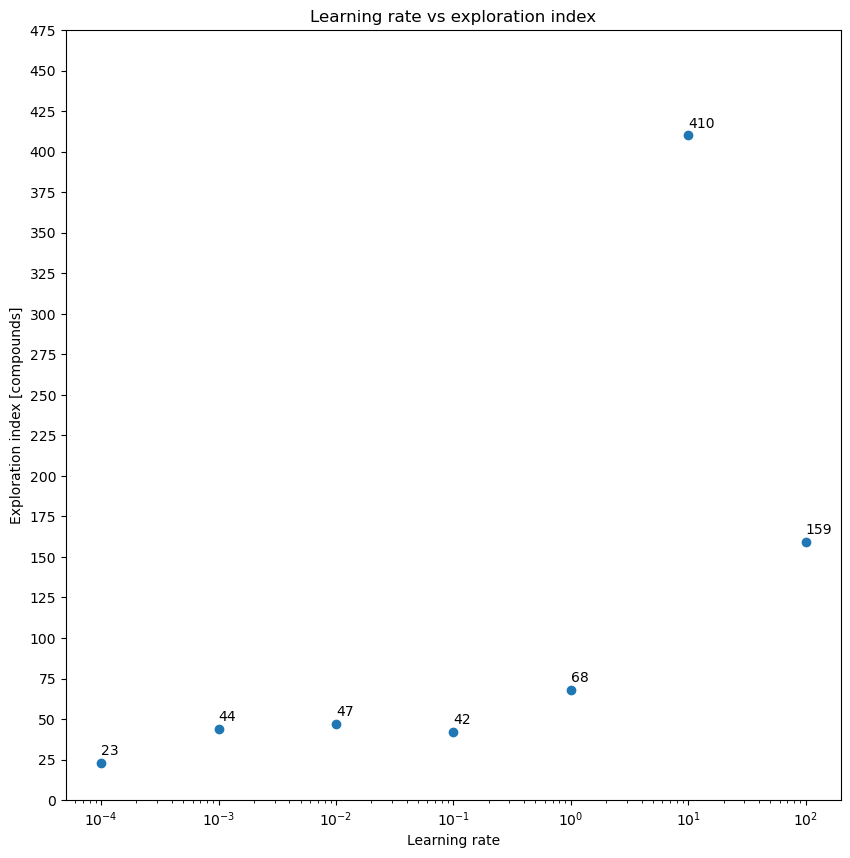

In [45]:
# plot learning rate vs exploration index plot in log scale
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(lrs, exploration_index, 'o')
ax.set_xscale('log')
#add y ticks for exploration index
ax.set_yticks(range(0, 500, 25))
for i, txt in enumerate(exploration_index):
    ax.annotate(txt, (lrs[i], exploration_index[i]+5))
ax.set_xlabel('Learning rate')
ax.set_ylabel('Exploration index [compounds]')
ax.set_title('Learning rate vs exploration index')
plt.show()

In [46]:
for lr in lrs:
    print(f'Best score for lr={lr}: {np.min(lrs_timeline[lr]):.3f}')

Best score for lr=0.0001: -12.122
Best score for lr=0.001: -13.434
Best score for lr=0.01: -16.128
Best score for lr=0.1: -16.081
Best score for lr=1: -14.548
Best score for lr=10: -14.880
Best score for lr=100: -13.867


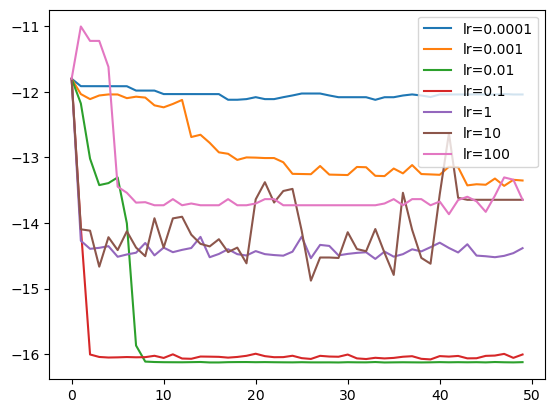

In [47]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [48]:
from scipy import stats

In [49]:
#percentile of each best logP
for lr, exp in zip(lrs, exploration_index):
    print(f'Percentile of best score for lr={lr}: {stats.percentileofscore(target, np.min(lrs_timeline[lr]))} with {exp} samples')

Percentile of best score for lr=0.0001: 26.161212880329835 with 23 samples
Percentile of best score for lr=0.001: 3.6702155419863263 with 44 samples
Percentile of best score for lr=0.01: 0.037837273628725014 with 47 samples
Percentile of best score for lr=0.1: 0.037837273628725014 with 42 samples
Percentile of best score for lr=1: 0.45796148426491307 with 68 samples
Percentile of best score for lr=10: 0.21528103961171127 with 410 samples
Percentile of best score for lr=100: 1.7666092583894368 with 159 samples


In [50]:
# calcuate probability of each best logP is sampled from target distribution
for lr, exp in zip(lrs, exploration_index):
    samples = np.random.choice(target, exp)
    if exp == 0:
        print(f'Probability of best score for lr={lr}: 0 with {exp} samples')
    else:
        print(f'Probability of best score for lr={lr}: {np.sum(samples < np.min(lrs_timeline[lr])) / exp} with {exp} samples')


Probability of best score for lr=0.0001: 0.21739130434782608 with 23 samples
Probability of best score for lr=0.001: 0.06818181818181818 with 44 samples
Probability of best score for lr=0.01: 0.0 with 47 samples
Probability of best score for lr=0.1: 0.0 with 42 samples
Probability of best score for lr=1: 0.0 with 68 samples
Probability of best score for lr=10: 0.0024390243902439024 with 410 samples
Probability of best score for lr=100: 0.03773584905660377 with 159 samples


In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(space.mol2vec)

PCA(n_components=2)

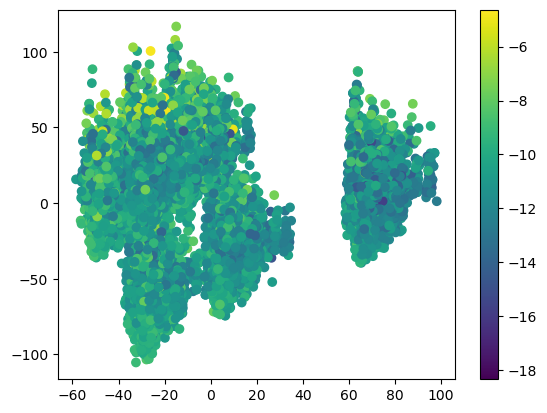

In [52]:
# plot PCA of mol2vec, use target as color
_ = plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target[:30000], cmap='viridis')
plt.colorbar()

In [53]:
# test evrything with lr 10
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
optimizer = Adam([X], lr=0.01)
CALLS = []
history = np.zeros(2000)

Global seed set to 676550


In [54]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(2000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -11.800604283433183, neighbors: [[ 8263  2837 16780 19436 29650 26083 12678  7318 25891 17207]]
Iteration 100: -12.17725691278613, neighbors: [[16780  8263  7318 19571 26083 24175  3393 19115 15828 22334]]
Iteration 200: -13.019136118281102, neighbors: [[ 8444 16780 19571 28204  4736 21592 10301  2267  5465 18720]]
Iteration 300: -13.422779419698216, neighbors: [[ 8444 28204  4736 10301 21592  9168 12213 19571 16780 14147]]
Iteration 400: -13.392307933903522, neighbors: [[ 8444 10301 28204  4736 21592  9168 12213 18816 19571  4374]]
Iteration 500: -13.305830469001913, neighbors: [[ 8444 10301 21592 28204  4736  9168  5465  2827 18816 19571]]
Iteration 600: -14.005241617425998, neighbors: [[ 8444 10301 21592  5465  2827 19571 21418 24109  9168 18816]]
Iteration 700: -15.869838809183356, neighbors: [[ 8444 10301 21592  5465  2827 21418 24109 19571  9168 16235]]
Iteration 800: -16.114612339688804, neighbors: [[ 8444 10301 21592  5465  2827 21418 24109  9168 19571  4374]]
Iter

In [55]:
space.get_neighbors(X.detach().numpy())
for i in space.get_neighbors(X.detach().numpy())[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


In [56]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 47 unique compounds
Best score: -16.129409050400238
Percentile: 0.037837273628725014
Best f(X): -16.11413353977555


In [57]:
space.f(best_X)

tensor(-16.1141, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [58]:
np.sum(target < best)

29

In [59]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


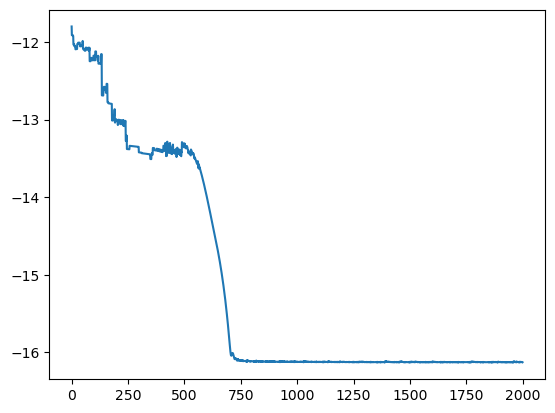

In [60]:
_ = plt.plot(history)

In [61]:
best_X

tensor([ 10.7435, -12.4907, -13.9022,  20.4168,  -9.2623,  -5.1384, -37.6056,
          2.8812,  28.2282,  17.6497, -10.0176,  -5.8981, -34.4853,   3.4457,
        -19.6775,  -6.9179,  13.5116, -13.8149, -16.3957,  26.5857,  14.7813,
         22.0685,  54.5305,  27.5932, -38.3574,   4.2319,  -1.9942, -32.2904,
         -0.8080,   1.4150,  42.4188, -26.1582, -12.4401, -18.9406,  17.9271,
          7.7917,   6.7873,  -2.6793,  32.5897,   9.0254,  -9.4453,  -2.4397,
        -11.8076,  -0.8447, -42.3179,  26.6574,   0.0819,  30.7090, -21.4143,
         15.7186,  20.1684, -21.8772,  -8.4330, -26.7457, -26.0855, -15.3500,
        -14.5754,   0.4629,  11.9352,  17.0587,  -8.0730, -31.2048,  -7.6596,
         12.6071, -49.0992,  -2.6900,  34.7361,   0.0627,  -6.9172,   4.2381,
        -18.2080,   5.9921,  25.7646, -20.9373,  -3.5780,  18.8211, -11.5482,
         12.7517,  -3.8737,   6.8868,  18.2838,  -7.1739, -15.0996, -40.6798,
          8.9273, -10.4790, -26.5929,  16.1466,  14.2246,  -9.23

In [62]:
space.f(best_X)

tensor(-16.1141, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [63]:
space.get_neighbors(best_X)

array([[ 8444, 10301, 21592,  5465,  2827, 21418, 24109,  9168, 19571,
         4374]])

In [64]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


In [79]:
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))

In [80]:
def create_replica(n=5, steps=2000, lr=0.01):
    replica_dfs = []
    idxs = []
    for replica in tqdm(range(n)):
        space.reset_neighbors()
        print(f'Replica {replica}')
        global_seed(42 * replica)
        X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
        optimizer = Adam([X], lr=lr)
        CALLS = []
        history = np.zeros(steps)
        for i in range(steps):
            optimizer.zero_grad()
            loss = space.f(X)
            loss.backward()
            optimizer.step()
            history[i] = loss.item()
        res = pd.DataFrame({'step': range(steps), 'loss': history})
        res['replica'] = replica
        replica_dfs.append(res)
        idxs.append(unique_comps(space.iter_neighbors))
    return pd.concat(replica_dfs), idxs

In [95]:
lr_comp = []
exp_idxs = []
for lr in lrs:
    res, exp_id = create_replica(50, lr=lr, steps=2000)
    lr_comp.append(res)
    exp_idxs.append(exp_idxs)

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

  0%|          | 0/50 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Replica 25
Global seed set to 1050
Replica 26
Global seed set to 1092
Replica 27
Global seed set to 1134
Replica 28
Global seed set to 1176
Replica 29
Global seed 

In [86]:
v_0_01.shape

(500, 3)

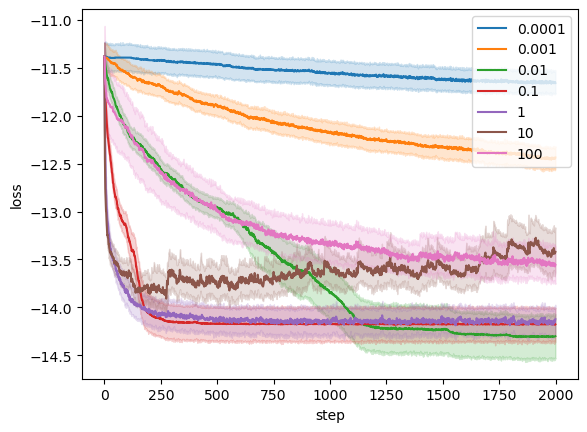

In [96]:
for df,lr in zip(lr_comp, lrs):
    sns.lineplot(data=df, x='step', y='loss',label=lr)
plt.legend()

In [97]:
all_res = pd.concat(lr_comp)
all_res.to_csv('lr_compare.csv')

In [98]:
all_res.shape

(700000, 3)

In [46]:
replica_dfs = []
steps = 2000
for replica in tqdm(range(50)):
    global_seed(42 * replica)
    X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
    optimizer = Adam([X], lr=0.01)
    CALLS = []
    history = np.zeros(steps)
    for i in range(steps):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        history[i] = loss.item()
    res = pd.DataFrame({'step': range(steps), 'loss': history})
    res['replica'] = replica
    replica_dfs.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 42
Global seed set to 84
Global seed set to 126
Global seed set to 168
Global seed set to 210
Global seed set to 252
Global seed set to 294
Global seed set to 336
Global seed set to 378


In [106]:
global_seed(7543)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=0.01)
CALLS = []
history = np.zeros(5000)
X_positions = np.zeros((5000, 300))
x_scores = np.zeros(5000)

Global seed set to 7543


In [107]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(5000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    X_positions[i] = X.detach().numpy()
    x_scores[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -12.03277509001683, neighbors: [[ 3727 24054  3393  3754  7318  3169 19115 21022 18816 21510]]
Iteration 100: -12.543472542555204, neighbors: [[ 3393 18816 24054 12331  7195  1903  2346 21022  8263 22135]]
Iteration 200: -12.777129007426996, neighbors: [[18816  7195  1903 14607  3393  2346 12331 13643 16764 22135]]
Iteration 300: -12.915469165037802, neighbors: [[14607  1903 13643 18816 15598  7195 16764 29741  3639  1696]]
Iteration 400: -12.944364307112796, neighbors: [[14607 18816 13643 15598 29741  1903  1696 24267   118  3639]]
Iteration 500: -13.077565788584934, neighbors: [[14607 29741 13643 15598   966   118 24267 18816  1696 13298]]
Iteration 600: -13.092579012713255, neighbors: [[14607 29741   966  2118   118 13643 15598 24267  1696 10225]]
Iteration 700: -13.129971681566943, neighbors: [[14607   966  2118 29741   118 13643 15598  1696  5997 19727]]
Iteration 800: -13.090865080195238, neighbors: [[14607  2118   966 29741 11494   118  5997 24267  1696  3639]]
Iter

In [108]:
from scipy.stats import percentileofscore
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 68 unique compounds
Best score: -13.964801407506098
Percentile: 1.4547779343458065
Best f(X): -13.958234035931069


In [110]:
space.get_neighbors(best_X.detach().numpy())
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-13.966666666666669
-12.633333333333333
-12.566666666666668
-11.966666666666669
-12.933333333333332
-12.566666666666668
-12.433333333333332
-13.6
-12.066666666666665
-12.233333333333334


In [109]:
# ne

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
all_points = np.concatenate((space.mol2vec, X_positions), axis=0)
all_tsne = tsne.fit_transform(all_points)

In [135]:
# separate mol2vec and X_positions
mol2vec_tsne = all_tsne[:space.mol2vec.shape[0]]
X_positions_tsne = all_tsne[space.mol2vec.shape[0]:]

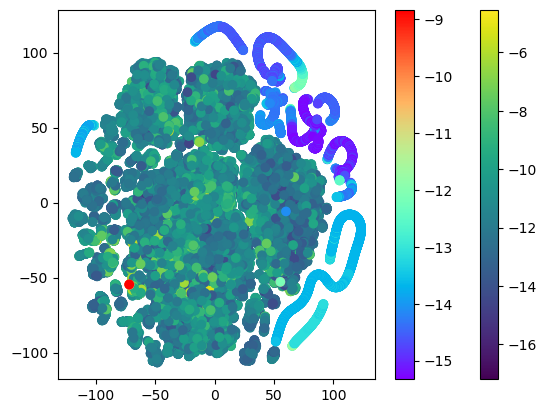

In [147]:
# plot TSNE of mol2vec, use target as color
_ = plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target, cmap='viridis')
_ = plt.colorbar()
_ = plt.scatter(X_positions_tsne[:, 0], X_positions_tsne[:, 1], c=x_scores, cmap='rainbow')
# add two colorbar with name
plt.colorbar()

In [73]:
X_positions_pca = pca.transform(X_positions)

In [148]:
!mkdir images_tsne

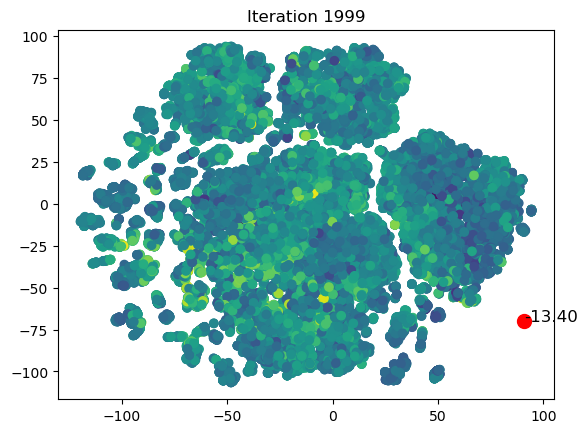

In [150]:
import imageio
images = []
for i in range(0, 2000, 1):
    plt.clf()
    plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target, cmap='viridis')
    plt.scatter(X_positions_tsne[i, 0], X_positions_tsne[i, 1], c='red', s=100)
    plt.text(X_positions_tsne[i, 0], X_positions_tsne[i, 1], f'{x_scores[i]:.2f}', fontsize=12)
    plt.title(f'Iteration {i}')
    plt.savefig(f'images_tsne/{i}.png')
    images.append(imageio.v2.imread(f'images_tsne/{i}.png'))

In [151]:
# save as video
imageio.mimsave('movie_28k_lr10_tsne.mp4', images)